In [1]:
import IPython.display
import pandas
import np_session

In [2]:
import datetime
import pathlib  
import shutil
import time
import pprint
from typing import Generator, Optional
import IPython.display

import np_session
from np_session import Session, PipelineSession, sessions as get_sessions
from np_tools import get_files_created_between, ssh

problem_sessions = [
    
]

def npexp_sessions(skip_already_checked=True) -> Generator[PipelineSession, None, None]:
    for session in get_sessions('TTN'):
        if any(_ in str(session) for _ in problem_sessions) and skip_already_checked:
            continue
        yield session

sessions: Generator[PipelineSession, None, None] = npexp_sessions()

In [35]:
session = next(sessions)
session.get_missing_files()

()

Cleanup files before transfer

In [53]:
if session.project.parent.name == 'DR':
    for _ in session.npexp_path.glob('*surface-image*'):
        for replace in ('-right', '-left'):
            if replace in _.name:
                _.replace(_.parent / _.name.replace(replace, ''))
for _ in session.npexp_path.glob('*platform*.bak'):
    _.unlink()
for _ in session.npexp_path.glob('*platform*D0*json'):
    _.unlink()

In [54]:
names = session.D1.names + session.D2.names
globs = session.D1.globs + session.D2.globs
paths = session.D1.paths + session.D2.paths
types = session.D1.types + session.D2.types

print(session.npexp_path)
display(df := pandas.DataFrame(({'glob': glob, 'exists': path.name if path else None} for glob, path in zip(globs, paths)), index=names))

\\allen\programs\mindscope\workgroups\np-exp\1254438930_661730_20230316


,glob,exists
ephys_raw_data_probe_A,*_probeABC,1254438930_661730_20230316_probeABC
ephys_raw_data_probe_B,*_probeABC,1254438930_661730_20230316_probeABC
ephys_raw_data_probe_C,*_probeABC,1254438930_661730_20230316_probeABC
ephys_raw_data_probe_D,*_probeDEF,1254438930_661730_20230316_probeDEF
ephys_raw_data_probe_E,*_probeDEF,1254438930_661730_20230316_probeDEF
ephys_raw_data_probe_F,*_probeDEF,1254438930_661730_20230316_probeDEF
synchronization_data,*.sync,1254438930_661730_20230316.sync
behavior_tracking,*.behavior.mp4,1254438930_661730_20230316.behavior.mp4
beh_cam_json,*.behavior.json,1254438930_661730_20230316.behavior.json
eye_tracking,*.eye.mp4,1254438930_661730_20230316.eye.mp4


('A', 'B', 'C', 'D', 'E')


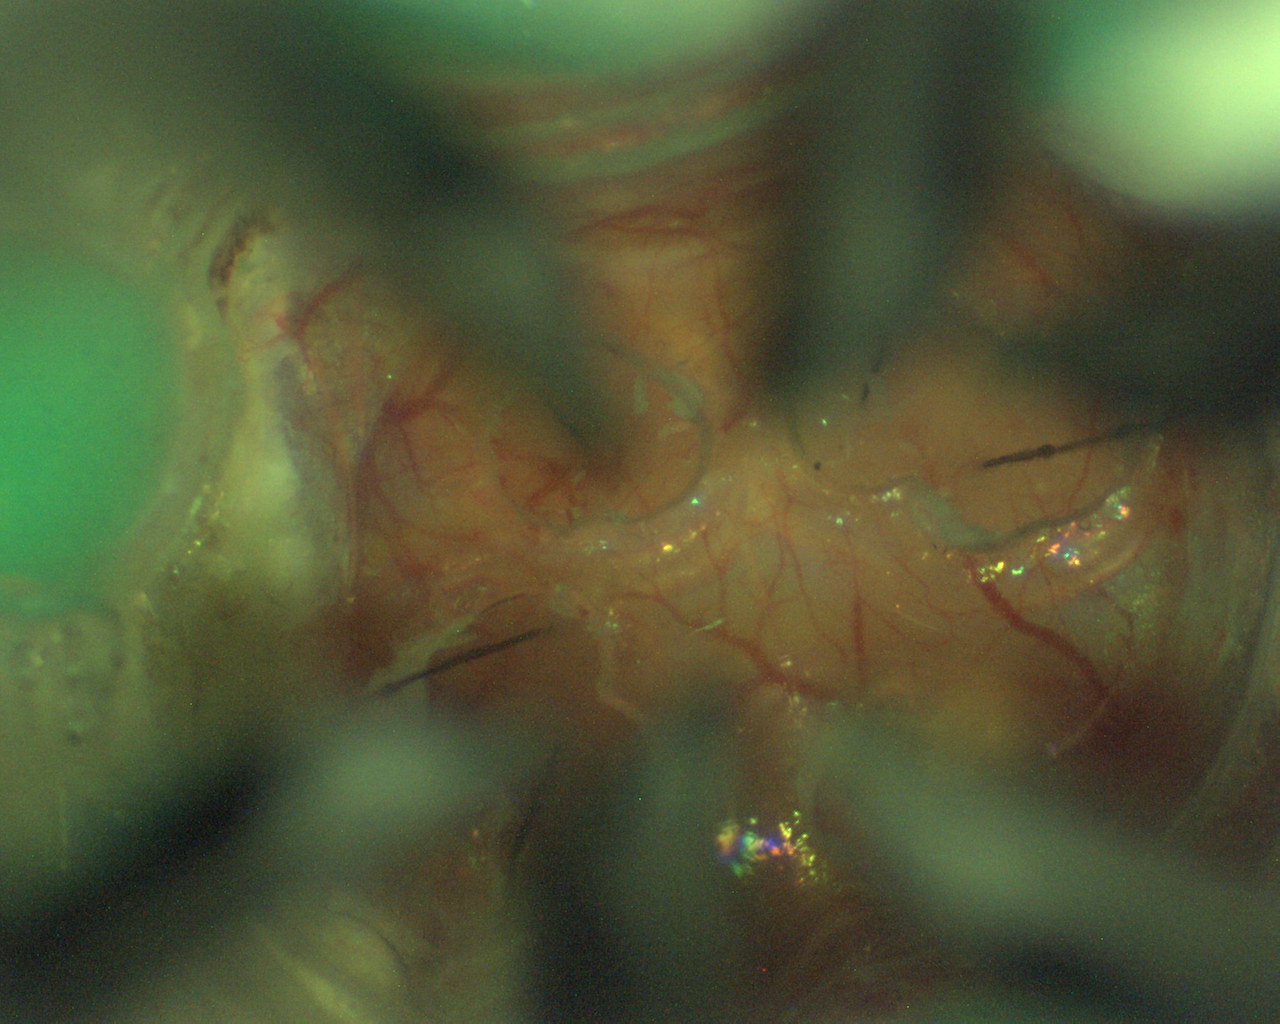

In [43]:
print(session.probes_inserted)
from IPython.display import Image
Image(session.npexp_path / df.loc['post_insertion_surface_image_left']['exists'])

In [44]:
session.probes_inserted = 'ABCDEF'

In [45]:
if not all(paths) or not all(df['exists'].values):
    raise Warning('Some files are missing - continue with upload at your own risk!')
else:
    print('All files exist')

All files exist


In [46]:
for _ in paths:
    if _ and str(session.id) not in _.name:
        print(f'Warning! File name does not contain session id: {_.name}')
else:
    print('All filenames contain session id')


All filenames contain session id


Get D1 & D2 `files` dicts for platform json - the manifests for uploading to LIMS

In [55]:
files = (session.D1.files | session.D2.files)

Remove surface images that don't exist: Ryan searched for missing files
already, so folders on np-exp now are as complete as possible

In [56]:
for idx, name in enumerate(names):
    if '_surface_image_' in name and paths[idx] is None:
        del files[name]

If a file or dir has already been uploaded to lims, the upload job can fail. 

Remove from the upload manifest:

In [57]:
if session.lims_path:    
    for name, path, glob in zip(names, paths, globs):
        
        if (
            (path and (file_on_lims := (session.lims_path / path.name)).exists())
            or (glob and (file_on_lims := (next(session.lims_path.rglob(glob), None))) and file_on_lims.exists())
        ):
            print(f'File or dir has already been uploaded:\n\t', file_on_lims, '\n')
            
            if name in files:
                del files[name]
                print(f'\tRemoved from upload manifest\n')

session.platform_json.files = files

In [58]:
IPython.display.JSON(session.platform_json.path)

<IPython.core.display.JSON object>

Set up files required for transfer in scratch space

In [59]:
import datetime
import pathlib

scratch = pathlib.Path('//allen/scratch/aibstemp/svc_neuropix/lims_uploads')
scratch.mkdir(parents=True, exist_ok=True)

file_manifest = scratch / f'{session.id}_{datetime.datetime.now():%Y-%m-%d_%H%M}.txt'
file_manifest.touch(exist_ok=True)

log = file_manifest.with_suffix('.log')
log.touch(exist_ok=True)

shell_script = file_manifest.with_suffix('.sh')
shell_script.touch(exist_ok=True)

Write manifest of relative file paths, including specific sorted data files (not just
sorted probe folders)

In [60]:
src_file_list = []
sorted_files = []
for name, path in zip(names, paths):
    
    if path is None or name not in session.platform_json.files:
        continue    
    
    # specify selection of sorted data files to transfer (excl. AP continuous.dat)
    if name in tuple(f'ephys_raw_data_probe_{_}_sorted' for _ in 'ABCDEF'):
        sorted_files = session.D2.paths_sorted_data if sorted_files == [] else sorted_files
        
        #TODO LFP continuous.dat might be deleted - write symlinks to raw copy on npexp/lims
        src_file_list.extend(_ for _ in sorted_files if path in _.parents) #if path is None this should raise 
        continue
    
    src_file_list.append(path)
    
# add platform json last as a sentinel for successful transfer 
src_file_list.append(session.platform_json.path)

if any(missing := tuple(_ for _ in src_file_list if not _.exists())):
    raise FileNotFoundError('Some files do not exist: ', missing)

file_manifest.write_text(
    '\n'.join(_.relative_to(session.npexp_path).as_posix() for _ in src_file_list),
    newline='\n'
    )
print(file_manifest.read_text())

1254438930_661730_20230316_probeABC
1254438930_661730_20230316_probeABC
1254438930_661730_20230316_probeABC
1254438930_661730_20230316_probeDEF
1254438930_661730_20230316_probeDEF
1254438930_661730_20230316_probeDEF
1254438930_661730_20230316.sync
1254438930_661730_20230316.behavior.mp4
1254438930_661730_20230316.behavior.json
1254438930_661730_20230316.eye.mp4
1254438930_661730_20230316.eye.json
1254438930_661730_20230316.face.json
1254438930_661730_20230316.face.mp4
1254438930_661730_20230316.motor-locs.csv
1254438930_661730_20230316_surface-image1-right.png
1254438930_661730_20230316_surface-image2-right.png
1254438930_661730_20230316_surface-image3-right.png
1254438930_661730_20230316_surface-image4-right.png
1254438930_661730_20230316_surface-image5-right.png
1254438930_661730_20230316_surface-image6-right.png
1254438930_661730_20230316_surface-image1-left.png
1254438930_661730_20230316_surface-image2-left.png
1254438930_661730_20230316_surface-image3-left.png
1254438930_661730_20

In [61]:
pathlib.Path(session.project.lims['trigger_dir']).parent


WindowsPath('/allen/programs/mindscope/production/incoming')

In [62]:
INCOMING = pathlib.Path(session.project.lims['trigger_dir']).parent

In [63]:
rsync_cmd = f'rsync -Larv --log-file={file_manifest.with_suffix(".log").as_posix()} --files-from={file_manifest.as_posix()} {session.npexp_path.as_posix()} {INCOMING.as_posix()}'
# -a archive mode
# -r recursive (for dirs)
# -v verbose
# -L copy the data that symlinks point to
rsync_cmd

'rsync -Larv --log-file=//allen/scratch/aibstemp/svc_neuropix/lims_uploads/1254438930_2023-05-16_2124.log --files-from=//allen/scratch/aibstemp/svc_neuropix/lims_uploads/1254438930_2023-05-16_2124.txt //allen/programs/mindscope/workgroups/np-exp/1254438930_661730_20230316 /allen/programs/mindscope/production/incoming'

Write shell script for the transfer

In [64]:
shell_script_cmd = f"""#!/bin/bash
#SBATCH --job-name=npexp_to_incoming                        # Job name
#SBATCH --mail-type=END,FAIL                                # Mail events (NONE, BEGIN, END, FAIL, ALL)
#SBATCH --mail-user=ben.hardcastle@alleninstitute.org       # Where to send mail  
#SBATCH --ntasks=1                                          # Run on a single CPU
#SBATCH --mem=4gb                                           # Job memory request (per node)
#SBATCH --time=02:00:00                                     # Time limit hrs:min:sec
#SBATCH --output=npexp_to_incoming_%j.log                   # Standard output and error log
#SBATCH --partition braintv                                 # Partition used for processing
#SBATCH --tmp=100M                                          # Request the amount of space your jobs needs on /scratch/fast
 
pwd; hostname; date
 
echo 'Running rsync job on a single thread'

{rsync_cmd}
 
date
"""

shell_script.write_text(shell_script_cmd, newline='\n') 
# if writing on Windows, newline=\r\n by default, which isn't compatible with bash on linux

1230

In [65]:
import fabric
import np_config

login = np_config.fetch('/logins')['svc_neuropix']
with fabric.Connection(
        host='svc_neuropix@hpc-login',
        connect_kwargs={'password': login['password']},
    ) as ssh:
    ssh.run(f'sbatch {shell_script.as_posix()}')

Submitted batch job 9339462


In [34]:
import time

destination_file_list = [INCOMING / _.relative_to(session.npexp_path) for _ in src_file_list]

while not all(_.exists() for _ in destination_file_list):
    print('Waiting for transfer to complete...\r', end='', flush=True)
    time.sleep(10)
    
print('\nTransfer complete')

KeyboardInterrupt: 

Check platform json for upload

In [ ]:
import shutil
dest_platform_json = INCOMING / session.platform_json.path.name
shutil.copy2(session.platform_json.path, dest_platform_json)
IPython.display.JSON(INCOMING / session.platform_json.path.name)

<IPython.core.display.JSON object>

In [ ]:
np_session.write_trigger_file(session, INCOMING, INCOMING / 'trigger')
print('Trigger file written')

No platform json found for 1226010097 in incoming dir - lims upload job will fail when triggered: \\allen\programs\braintv\production\incoming\neuralcoding


Trigger file written


In [ ]:
session.data_dict

{'es_id': '1179670730',
 'es': '20220524124446_704511589',
 'storage_directory': WindowsPath('//allen/programs/mindscope/production/dynamicrouting/prod0/specimen_1154273215/ecephys_session_1179670730'),
 'workflow_state': 'created',
 'date_of_acquisition': datetime.datetime(2022, 5, 24, 14, 26, 31, 876000),
 'stimulus_name': 'EPHYS_1',
 'foraging_id': '3fb9da761fcc479bb781a866340a3aa4',
 'external_specimen_name': '612090',
 'isi_experiment_id': 1158852793,
 'rig': 'NP.1',
 'operator': 'taminar',
 'project': 'DynamicRoutingSurgicalDevelopment',
 'behavior_dir': WindowsPath('//allen/programs/mindscope/production/dynamicrouting/prod0/specimen_1154273215/behavior_session_1179717742'),
 'SideDlcOutputFile': WindowsPath('//allen/programs/mindscope/production/dynamicrouting/prod0/specimen_1154273215/ecephys_session_1179670730/side_tracking/1179670730_612090_20220524.behaviorDeepCut_resnetNone_np3_side_camMar31shuffle1_1030000.h5'),
 'FaceDlcOutputFile': WindowsPath('//allen/programs/mindscope